# Observables classes

## `BaseObservable` inherited class

In [ ]:
from acm.observables.base import BaseObservable

# Using paths and summary coordinates dictionary from the EMC project as an example
from acm.projects.emc_new import emc_paths, emc_summary_coords_dict 

class TPCF(BaseObservable):
    """
    Defines the TPCF observable
    """
    
    def __init__(self, select_filters = None, slice_filters = None):
        super().__init__(select_filters, slice_filters)
        
    @property
    def stat_name(self):
        return "tpcf"
    
    @property
    def paths(self):
        return emc_paths
    
    @property
    def summary_coords_dict(self):
        return emc_summary_coords_dict

In [ ]:
select_filters = {'cosmo_idx': [0, 1], 'multipoles': [0]}
slice_filters = {'bin_values': [5, 30]}

tpcf = TPCF(
    select_filters=select_filters,
    slice_filters=slice_filters
)

# From the lhc file
lhc_x = tpcf.lhc_x
lhc_y = tpcf.lhc_y
bin_values = tpcf.bin_values
covariance_matrix = tpcf.get_covariance_matrix(volume_factor=64)
lhc_x_names = tpcf.lhc_x_names

# From the model
model = tpcf.model
emulator_error = tpcf.emulator_error
emulator_covariance = tpcf.get_emulator_covariance_matrix(prefactor=1)

# get a prediction
idx_pred = 0
prediction = tpcf.get_model_prediction(lhc_x[idx_pred], model)

print('lhc_y shape:', lhc_y.shape)
print('prediction shape:', prediction.shape)

lhc_y shape: (200, 25)
prediction shape: (25,)


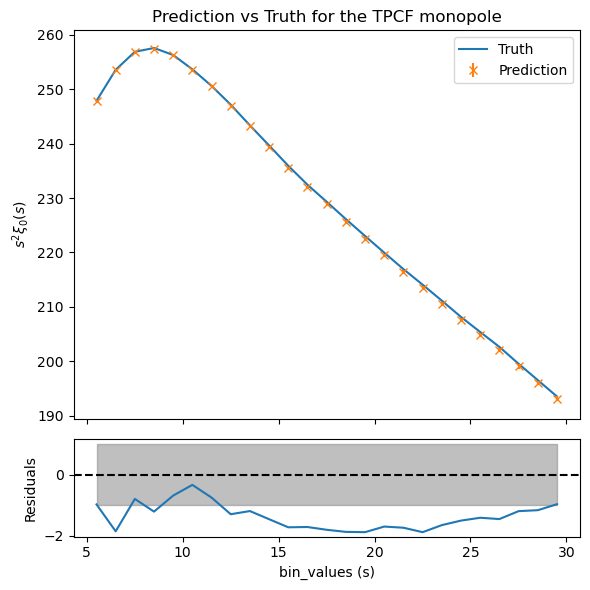

In [3]:
import matplotlib.pyplot as plt
import numpy as np

s = bin_values
truth = lhc_y[idx_pred] # Same index to compare with the prediction
pred = prediction
error = np.sqrt(np.diag(covariance_matrix))

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=[2, 0.5])

ax[0].plot(s, truth*s**2, label='Truth')
ax[0].errorbar(s, pred*s**2, yerr=error*s**2, fmt='x', label='Prediction')
ax[1].plot(s, (pred - truth)/error)
ax[1].axhline(0, color='k', linestyle='--')
ax[1].fill_between(s, -1, 1, color='gray', alpha=0.5)
ax[0].set_ylabel(r'$s^2 \xi_0(s)$')
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel('bin_values (s)')

ax[0].set_title('Prediction vs Truth for the TPCF monopole')
ax[0].legend()
fig.tight_layout();

## `CombinedObservable` class

In [4]:
from acm.observables.combined import BaseCombinedObservable as CombinedObservable

combined = CombinedObservable([
    TPCF(
        select_filters={'cosmo_idx': [0, 1], 'multipoles': [0]},
        slice_filters={'bin_values': [5, 30]}
    ),
    TPCF(
        select_filters={'cosmo_idx': [0, 1], 'multipoles': [2]}, # here, as example we use the quadrupole instead of a different observable
        slice_filters={'bin_values': [5, 30]}
    ),
])

idx_pred = 0
prediction = combined.get_model_prediction(lhc_x[idx_pred])
print('prediction shape:', prediction.shape)

prediction shape: (50,)


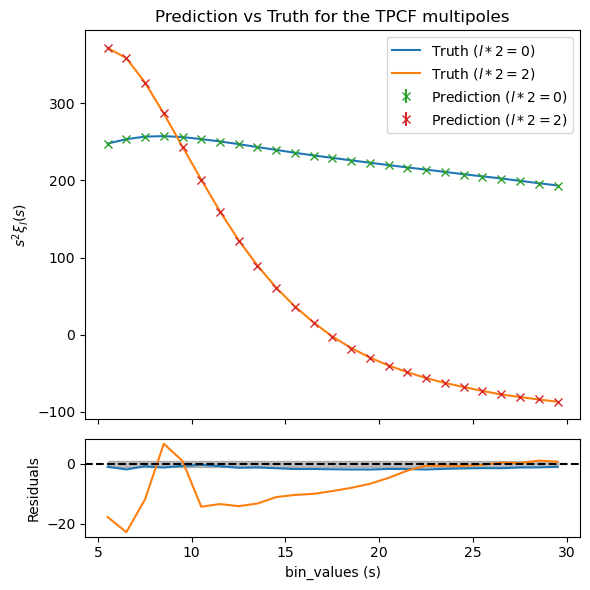

In [6]:
s = combined.bin_values
truth = combined.lhc_y[idx_pred] # Same index to compare with the prediction
pred = prediction
error = np.sqrt(np.diag(combined.get_covariance_matrix()))

# reshape
truth = truth.reshape(2, -1)
pred = pred.reshape(2, -1)
error = error.reshape(2, -1)
s = s.reshape(2, -1)

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=[2, 0.5])

for l in range(2):
    ax[0].plot(s[l], truth[l]*s[l]**2, label=fr'Truth (${l*2=}$)', color=f'C{l}')
    ax[0].errorbar(s[l], pred[l]*s[l]**2, yerr=error[l]*s[l]**2, fmt='x', label=fr'Prediction (${l*2=}$)', color=f'C{l+2}')

    ax[1].plot(s[l], (pred[l] - truth[l])/error[l], color=f'C{l}')
ax[1].axhline(0, color='k', linestyle='--')
ax[1].fill_between(s[0], -1, 1, color='gray', alpha=0.5)
ax[0].set_ylabel(r'$s^2 \xi_l(s)$')
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel('bin_values (s)')

ax[0].set_title('Prediction vs Truth for the TPCF multipoles')
ax[0].legend()
fig.tight_layout();